<a href="https://colab.research.google.com/github/M-torki/ECG-Classification/blob/main/MITBIH_data_preparation_Shayan_Like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##preparing test and train datasets according to Shayan Fazeli's paper:
[Shayan's paper](https://arxiv.org/pdf/1805.00794.pdf)

This notebook contains only data preparation, not classification.



##managing labels using below table:
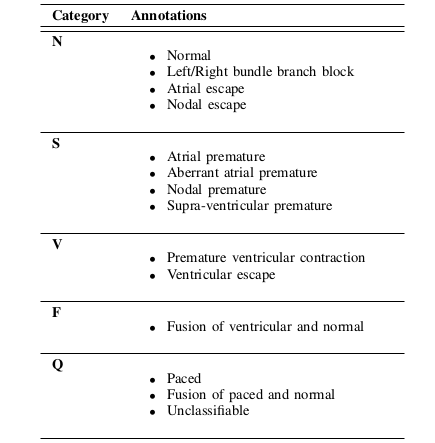

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wfdb

     |████████████████████████████████| 133kB 3.9MB/s 


In [ ]:
! pip install biosppy

     |████████████████████████████████| 92kB 2.8MB/s 


In [ ]:
! pip install neurokit2

     |████████████████████████████████| 993kB 4.0MB/s 


In [ ]:
import os
import numpy as np
import wfdb
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import biosppy
import scipy
import neurokit2 as nk
from wfdb.processing import resample_singlechan
from wfdb.plot import plot_items
from wfdb.processing import normalize_bound
from scipy.signal import find_peaks
from scipy.signal import resample

from wfdb import Annotation
from wfdb import show_ann_labels
from wfdb.processing import find_local_peaks

In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd physionet.org/files/mitdb/1.0.0/

/content/drive/.shortcut-targets-by-id/1Dr_lJtA5qEPKpVXRR04tuNmbeg4_tw9U/physionet.org/files/mitdb/1.0.0


In [ ]:
ls

100.atr    106.dat  113.hea  119.hea  202.atr  209.xws  217.xws  230.atr
100.dat    106.hea  113.xws  119.xws  202.dat  210.atr  219.atr  230.dat
100.hea    106.xws  114.atr  121.atr  202.hea  210.dat  219.dat  230.hea
100.xws    107.atr  114.dat  121.dat  202.xws  210.hea  219.hea  230.xws
101.atr    107.dat  114.hea  121.hea  203.at_  210.xws  219.xws  231.atr
101.dat    107.hea  114.xws  121.xws  203.at-  212.atr  220.atr  231.dat
101.hea    107.xws  115.atr  122.atr  203.atr  212.dat  220.dat  231.hea
101.xws    108.at_  115.dat  122.dat  203.dat  212.hea  220.hea  231.xws
102-0.atr  108.atr  115.hea  122.hea  203.hea  212.xws  220.xws  232.atr
102.atr    108.dat  115.xws  122.xws  203.xws  213.atr  221.atr  232.dat
102.dat    108.hea  116.atr  123.atr  205.atr  213.dat  221.dat  232.hea
102.hea    108.xws  116.dat  123.dat  205.dat  213.hea  221.hea  232.xws
102.xws    109.atr  116.hea  123.hea  205.hea  213.xws  221.xws  233.atr
103.atr    109.dat  116.xws  123.xws  205.xws  214.

In [ ]:
df = pd.read_csv("./RECORDS", header=None)
df.head()

,0
0,100
1,101
2,102
3,103
4,104


##reading signals and their annotation files (lead II) for 48 patients


In [ ]:
sig = list()
ann = list()


for i in range (48):
    if i != 13:
        sig.append(wfdb.rdsamp(str(df[0][i]), channels=[0])[0])
    if i == 13:
        sig.append(wfdb.rdsamp(str(df[0][i]), channels=[1])[0])    
    ann.append(wfdb.rdann(str(df[0][i]),'atr',summarize_labels=True))



##resampling from 360 Hz to 125 Hz

In [ ]:
resig = list()
reann = list()

for i in range (len(sig)):
    resig.append(resample_singlechan(sig[i][:,0],ann[i],360,125)[0])
    reann.append(resample_singlechan(sig[i][:,0],ann[i],360,125)[1])



In [ ]:
np.shape(resig)

(48, 225694)

##the number of samples in 10 seconds segment

In [ ]:
samples = 125*10
samples

1250

##each signal contains 180 number of 10 seconds segments

In [ ]:
225000/1250

180.0

In [ ]:
seg = list()

for i in range (len(resig)):
    seg.append(np.split(resig[i][0:225000], 1250))

seg = np.asarray(seg)
seg = np.reshape(seg, (48,180,1250))
np.shape(seg)

(48, 180, 1250)

##10 seconds segmented signal annotation

In [ ]:
an = np.empty((48,180), dtype='object')

for j in range (48):
    for k in range (180):
        a = list()
        for i in range (len(reann[j].sample)):
            if ((k*1250) < reann[j].sample[i] < ((k+1)*1250)):
                a.append(((reann[j].sample[i]-(k*1250)),reann[j].symbol[i])) 
        an[j][k] = a

np.shape(an)        

(48, 180)

##normalizing each segment between 0 and 1

In [ ]:
norm = np.empty_like(seg)

for i in range (len(seg)):
    for j in range(180):
        norm[i,j] = normalize_bound(seg[i,j],0,1)

norm = np.asarray(norm)
np.shape(norm)        

(48, 180, 1250)

##finding the location of each peak using annotation sample

In [ ]:
peaks = np.empty((48,180), dtype='object')
for i in range (48):
    for j in range (180):
        a = list()
        for k in range (len(an[i,j])):
            a.append(an[i,j][k][0])
        peaks[i,j] = a            

##finding the label of each peak using annotation symbol

In [ ]:
label = np.empty((48,180), dtype='object')

for i in range (48):
    for j in range (180):
        a = list()
        for k in range (len(an[i,j])):
            a.append(an[i,j][k][1])
        label[i,j] = a                    

##Finding the median of R-R time intervals as the nominal heartbeat period of that window (T )

In [ ]:
T = np.empty((48,180))

for i in range (48):
    for j in range (180):
        a = peaks[i,j]
        if len(a)>1 :
            b = peaks[i,j][1:]
            c = list()
            for k in range (len(b)):
                c.append(np.abs(a[k]-b[k]))
            T[i,j] = np.median(c)/(125)
        if len(a)==1:
            if len(peaks[i,j]) == 0:
                print(i,j)
                T[i,j] = 0
            else:    
                T[i,j] = peaks[i,j]/125
np.shape(T)

(48, 180)

##For each R-peak, selecting a signal part with the length equal to 1.2T and Padding each selected part with zeros to make its length equal to a predefined fixed length

In [ ]:
data = np.empty((48,180), dtype='object')

for i in range (48):
    for j in range (180):
        t = T[i,j]
        peak = peaks[i,j]
        h = list()
        for k in range (len(peak)):
            start , end = (peaks[i][j][k]), (peaks[i][j][k]+int(125*(1.2*t)))
            if (end>1250):
                end = 1250
            e1 = norm[i][j, start:end]    
            if (len(e1) == 0):
                print('an empty array!')  
            if (len(e1)==186):
                h.append(e1)  
                 
            if (len(e1)<186):
                e = np.pad(e1,(0,186-len(e1)), mode = 'constant')
                h.append(e)
                
            if (len(e1)>186):
                e = resample(e1, num = 186)
                h.append(e)
                 

             
                         
        data[i,j] = h

np.shape(data)        

(48, 180)

##checking if their length are equal

In [ ]:
for i in range (48):
    for j in range (180):
        peak = peaks[i,j]
        data1 = data[i][j]
        for k in range (len(peak)):
            if (len(data1[k])!= 186):
                print('noo!')


In [ ]:
cd -

/content/drive/MyDrive


In [ ]:
cd mit-bih-arrhythmia-database-1.0.0

/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0


In [ ]:
mkdir MIT-BIH

In [ ]:
cd MIT-BIH/

/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/MIT-BIH


##saving beats from specific patient as a dataframe for later use

In [ ]:
for i in range (48):
    for j in range (180):
        dataframe0 = pd.DataFrame(data[i][j], columns=[x for x in range (186)])
        dataframe1 = pd.DataFrame(label[i][j], columns=['Label']) 
        dataframe2 = pd.concat([dataframe0, dataframe1], axis = 1, ignore_index=True)
        dataframe3 = dataframe2.dropna(axis=0, how='any')
        dataframe3.to_csv('dataframe{},{}.csv'.format(i,j))       

##reading mentioned beats

In [ ]:
import pandas as pd
import glob

path = r'./' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, ignore_index=True)

In [ ]:
df1 = frame
df1 = df1.drop(labels=['Unnamed: 0'], axis=1)

##the number of beats with mentioned label

In [ ]:
labels = df1['186']
equilibre = labels.value_counts()
print(equilibre)

N    74742
L     8050
R     7234
V     7108
/     6999
A     2528
+     1287
f      979
F      801
~      611
!      471
"      436
j      229
x      192
a      149
|      132
E      105
J       83
Q       33
e       16
[        6
]        6
S        2
Name: 186, dtype: int64


##managing labels using below table:
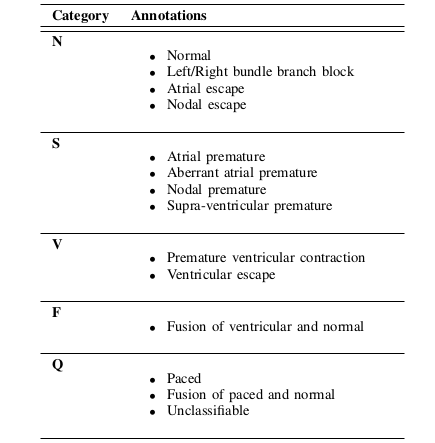

In [ ]:
df1 = df1.replace({'186': {'/': 'Q', 'f': 'Q', ']': 'Q', '~':'Q', '!': 'Q', '"': 'Q', '+':'Q', '|': 'Q', 'x': 'Q', '[': 'Q'}})
df1 = df1.replace({'186': {'e': 'N', 'L': 'N','R':'N', 'j': 'N'}})
df1 = df1.replace({'186': {'A': 'S', 'J': 'S', 'a': 'S'}})
df1 = df1.replace({'186': {'E': 'V'}})
df1 = df1.replace({'186': {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}})

##spliting test and train datasets with 20% ratio

In [ ]:
n = df[df['186'] == 0]
test0 = n[:18054]
train0 = n[18054:]

s = df[df['186'] == 1]
test1 = s[:552]
train1 = s[552:]

v = df[df['186'] == 2]
test2 = v[:1442]
train2 = v[1442:]

f = df[df['186'] == 3]
test3 = f[:160]
train3 = f[160:]

q = df[df['186'] == 4]
test4 = q[:2230]
train4 = q[2230:]



In [ ]:
cd -

/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0


##saving test dataset to csv

In [ ]:
test = pd.concat([test0, test1, test2, test3, test4], ignore_index=True)
test.to_csv('MITBIHtest.csv')

##saving train dataset to csv

In [ ]:
train = pd.concat([train0, train1, train2, train3, train4], ignore_index=True)
train.to_csv('MITBIHtrain.csv')